In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
from statistics import median
from rsi import apply as rsi

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Generate data like a sine wave data
Fs = 500
f = 5
x = np.arange(4000)
data = np.sin(2 * np.pi * f * x / Fs)

In [3]:
price_data = pd.DataFrame(data, columns=['price'])
price_data['price'] = (price_data['price'] * 100) + 300

# Add column for RSI to use as a feature for learning
price_data['rsi'] = rsi(price_data['price'])
environment_columns = ['rsi', 'price']

# Drop NA columns and reset index
price_data.dropna(inplace=True)

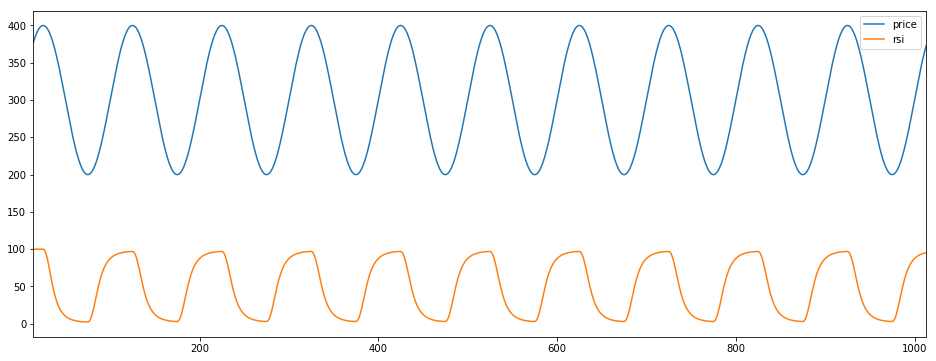

In [4]:
price_data[['price', 'rsi']].iloc[:1000].plot(figsize=(16,6))

In [5]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(drop=True, inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(drop=True, inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 2657, test size 1329


In [6]:
episode=600
batch_size=2

In [7]:
train_data.head(30)

,price,rsi
0,377.051324,100.000000
1,380.901699,100.000000
2,384.432793,100.000000
3,387.630668,100.000000
4,390.482705,100.000000
5,392.977649,100.000000
6,395.105652,100.000000
7,396.858316,100.000000
8,398.228725,100.000000
9,399.211470,100.000000


In [8]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [9]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0}, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist())),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    if (e + 1) % 10 == 0:
        agent.save('{}-dqn.h5'.format(time.strftime('%Y%m%d%H%M')))



....................
episode: 20/600
median profit: 3580, median trade count: 1164
....................
episode: 40/600
median profit: -182, median trade count: 470
....................
episode: 60/600
median profit: -84, median trade count: 453
....................
episode: 80/600
median profit: -26, median trade count: 454
....................
episode: 100/600
median profit: 105, median trade count: 476
....................
episode: 120/600
median profit: 210, median trade count: 471
....................
episode: 140/600
median profit: 223, median trade count: 478
....................
episode: 160/600
median profit: 279, median trade count: 476
....................
episode: 180/600
median profit: 460, median trade count: 503
....................
episode: 200/600
median profit: 556, median trade count: 522
....................
episode: 220/600
median profit: 764, median trade count: 551
....................
episode: 240/600
median profit: 921, median trade count: 585
...............

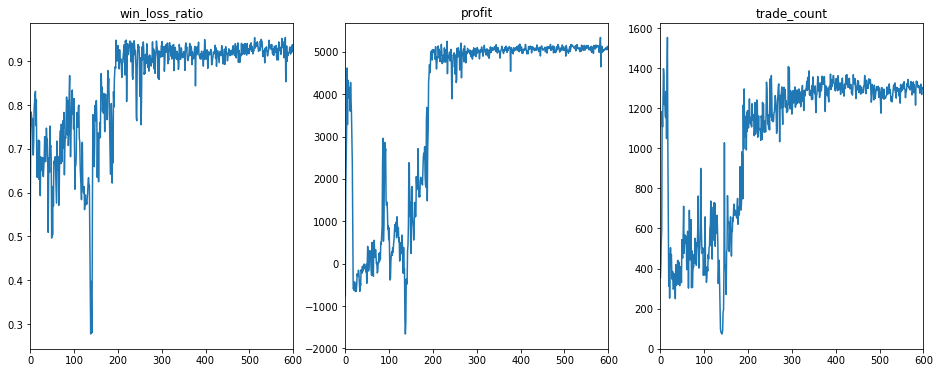

In [10]:
train_results['profit'] = train_results['account_balance']
columns_to_plot = ['win_loss_ratio', 'profit', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

## Test

In [11]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

# Uncomment to load trained model from latest saved
# agent = DQNAgent(state_size, action_size)
# latest_model_file = max(glob.glob('*.h5'), key=os.path.getctime)
# print('loading model: {0}'.format(latest_model_file))
# agent.load(latest_model_file)

In [12]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [13]:
print('Median profit: ${0}'.format(round(test_results['account_balance'].median())))

Median profit: $2557.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138336610>]],
      dtype=object)

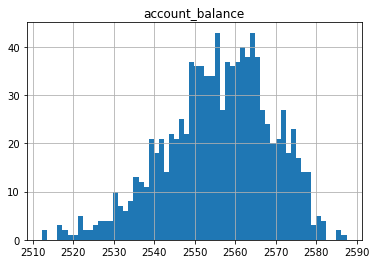

In [14]:
test_results.hist(column='account_balance', bins=60)